# Web Scraping for Reddit & Predicting Comments

In this project, we will practice two major skills. Collecting data by scraping a website and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to the overall interaction (as measured by number of comments)?_

Your method for acquiring the data will be scraping the 'hot' threads as listed on the [Reddit homepage](https://www.reddit.com/). You'll acquire _AT LEAST FOUR_ pieces of information about each thread:
1. The title of the thread
2. The subreddit that the thread corresponds to
3. The length of time it has been up on Reddit
4. The number of comments on the thread

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts whether or not a given Reddit post will have above or below the _median_ number of comments.

**BONUS PROBLEMS**
1. If creating a logistic regression, GridSearch Ridge and Lasso for this model and report the best hyperparameter values.
1. Scrape the actual text of the threads using Selenium (you'll learn about this in Webscraping II).
2. Write the actual article that you're pitching and turn it into a blog post that you host on your personal website.

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. Use BeautifulSoup to parse the page and extract all results

In [7]:
import requests
from bs4 import BeautifulSoup
import numpy as np
from random import randint
from time import sleep
import pandas as pd
import time
import nltk

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [811]:
base_url = "http://www.reddit.com"

response = requests.get(base_url, headers= {'User-Agent': 'whatever'})

In [813]:
response.status_code

200

In [814]:
html = response.text

soup = BeautifulSoup(html, 'lxml')

### Check out the html

In [766]:
print(soup.prettify())

<!DOCTYPE html>
<html lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml">
 <head>
  <title>
   reddit: the front page of the internet
  </title>
  <meta content=" reddit, reddit.com, vote, comment, submit " name="keywords"/>
  <meta content="reddit: the front page of the internet" name="description"/>
  <meta content="always" name="referrer"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <link href="/static/opensearch.xml" rel="search" type="application/opensearchdescription+xml"/>
  <link href="https://www.reddit.com/" rel="canonical"/>
  <meta content="width=1024" name="viewport"/>
  <link href="//out.reddit.com" rel="dns-prefetch"/>
  <link href="//out.reddit.com" rel="preconnect"/>
  <link href="//www.redditstatic.com/desktop2x/img/favicon/apple-icon-57x57.png" rel="apple-touch-icon" sizes="57x57"/>
  <link href="//www.redditstatic.com/desktop2x/img/favicon/apple-icon-60x60.png" rel="apple-touch-icon" sizes="60x60"/>
  <link href="//www.reddits

### Titles scrape testing

In [767]:
titles = soup.find_all('a',{'data-event-action':'title'} )
titles[0].text

"'One in a million' yellow cardinal spotted in Alabama"

In [768]:
titles = soup.find_all('a',{'data-event-action':'title'} )
titles[0]

<a class="title may-blank outbound" data-event-action="title" data-href-url="http://www.al.com/news/index.ssf/2018/02/one_in_a_million_yellow_cardinal.html" data-outbound-expiration="1519635764000" data-outbound-url="https://out.reddit.com/t3_809zjw?url=http%3A%2F%2Fwww.al.com%2Fnews%2Findex.ssf%2F2018%2F02%2Fone_in_a_million_yellow_cardinal.html&amp;token=AQAANM2TWnEhPN3u0pcPWtXRRqhT75hKK3V4IC_X-2A6RoBdAIDO&amp;app_name=reddit.com" href="http://www.al.com/news/index.ssf/2018/02/one_in_a_million_yellow_cardinal.html" rel="" tabindex="1">'One in a million' yellow cardinal spotted in Alabama</a>

### Times scrape testing

In [1106]:
times = soup.find_all('time',{'class':'live-timestamp'})
times[0].attrs

{'class': ['live-timestamp'],
 'datetime': '2018-02-26T01:36:16+00:00',
 'title': 'Mon Feb 26 01:36:16 2018 UTC'}

### Subreddits scrape testing

In [770]:
subreddits = soup.find_all('a',{'class':'subreddit hover may-blank'})
subreddits[0].text

'r/news'

In [771]:
subreddits[0].text[2:]

'news'

### Number of comments scrape testing

In [772]:
num_comments = soup.find_all('a',{'data-event-action':'comments'})
num_comments[23].text

'81 comments'

In [773]:
num_comments[0].text[:-9]

'291'

In [774]:
href = soup.findAll('a',{'rel':'nofollow next'})[0]['href']
href

'https://www.reddit.com/?count=25&after=t3_8080ml'

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The thread title is within an `<a>` tag with the attribute `data-event-action="title"`.
- The time since the thread was created is within a `<time>` tag with attribute `class="live-timestamp"`.
- The subreddit is within an `<a>` tag with the attribute `class="subreddit hover may-blank"`.
- The number of comments is within an `<a>` tag with the attribute `data-event-action="comments"`.

## Write 4 functions to extract these items (one function for each): title, time, subreddit, and number of comments.¶
Example
```python
def extract_title_from_result(result):
    return result.find ...
```

##### - Make sure these functions are robust and can handle cases where the data/field may not be available.
>- Remember to check if a field is empty or None for attempting to call methods on it
>- Remember to use try/except if you anticipate errors.

- **Test** the functions on the results above and simple examples

### Data exraction functions

In [799]:
#Titles
#titel()
def title(titles):
    '''
    title: Reddit post titles into a list
    '''
    title_list = []
    for title in soup.find_all('a',{'data-event-action':'title'} ):
        try:
            title_list.append(title.text)
        except:
            print('Error extracting titles.')
    return title_list

### Time
#time()
def times(soup):
    '''
    time:  Time stamp that reddit post was created on into a list
    '''
    time_list = []
    for time in soup.find_all('time',{'class':'live-timestamp'}):
        try:
            if time.has_attr('datetime'):
                time_list.append(time['datetime'])
        except: 
            print('Error extracting time stamp')
            break
    return time_list

### Subreddits
#subr()
def subr(subreddits):
    '''
    subreddits:  Subreddit categories for each post into a list
    '''
    subr_list = []
    for subs in soup.find_all('a',{'class':'subreddit hover may-blank'}):
        try:
            subr_list.append(subs.text[2:])
        except:
            print('Error extracting subreddits')
            break
    return subr_list

### Number of Comments
#numComments()
def numComments(num_comments):
    '''
    numComments: Number of comments for each post with the word 'comments' removed at the end
    '''
    numComments_list = []
    for comment in soup.find_all('a',{'data-event-action':'comments'}):
        try:
            numComments_list.append(comment.text[:-9])
        except:
            print('Error extracting # of comments')
            break
    return numComments_list

## ID of each reddit post
def user_id(id_soup):
    '''
    user_id: Post ID put into a list
    '''
    id_list = []
    for i in soup.find_all('div',{'onclick':'click_thing(this)'}):
        id_list.append(i['data-fullname'])
    return id_list    

## Author of each reddit post
#author
def author(id_soup):
    '''
    author:  Post composer's user name put into a list
    '''
    author_list = []
    for i in soup.find_all('div',{'onclick':'click_thing(this)'}):
        author_list.append(i['data-author'])
    return author_list 

#Vidoe tag
def video(soup):
    '''
    1: There is a video with the post
    0: There is no vidoe with the post
    '''
    list_not_textual = []
    tags = soup.find_all('div', {'class':'top-matter'})
    for tag in tags:
        if tag.find(name='div', attrs={'class':'expando-button collapsed hide-when-pinned video'}):
            list_not_textual.append(1)
        else:
            list_not_textual.append(0)
    return list_not_textual

#function to pull in the last id
def the_last_id(soup):
    '''
    last_id:  Pulls the last id of the page to use in the URL to indicated clicking on the "Next" button
    '''
    id_list = []
    for i in soup.find_all('div',{'onclick':'click_thing(this)'}):
        id_list.append(i['data-fullname'])
    return id_list[-1]   

# returns a number depending on whether a post is text, image, video, or podcast
def picture(soup):
    '''
    1:  There is a picture with the post
    0:  There is no picture with the post
    '''
    list_text_only = []
    tags = soup.find_all('div', {'class':'thing'})
    for i in tags:
        if i.find('a', {'class':'thumbnail invisible-when-pinned self may-blank '}):
            list_text_only.append(0)
        else:
            list_text_only.append(1)
    return list_text_only

## Scaling up scraping

Now, to scale up our scraping, we need to accumulate more results.

First, look at the source of a Reddit.com page: (https://www.reddit.com/).
Try manually changing the page by clicking the 'next' button on the bottom. Look at how the url changes.

After leaving the Reddit homepage, the URLs should look something like this:
```
https://www.reddit.com/?count=25&after=t3_787ptc
```

The URL here has two query parameters
- count is the result number that the page starts with
- after is the unique id of the last result on the _previous_ page

In order to scrape lots of pages from Reddit, we'll have to change these parameters every time we make a new request so that we're not just scraping the same page over and over again. Incrementing the count by 25 every time will be easy, but the bizarre code after `after` is a bit trickier.

## Now, let's put it all together.

Use the functions you wrote above to parse out the 4 fields - title, time, subreddit, and number of comments. Create a dataframe from the results with those 4 columns.

In [817]:
%%time
iterations = 300
max_pages = 100

count = 0

data = {}
data['titles'] = []
data['times'] = []
data['subreddits'] = []
data['comment_cnts'] = []
data['user_ids'] = []
data['authors'] = []
data['videos'] = []
data['pictures'] = []

last_id = None
reddits = pd.DataFrame.from_dict(data, orient='columns')

while count < iterations:
    for page in range(0, max_pages, 25):
        try:
            if last_id is None:
                url = "http://reddit.com/"
            else:
                url= "http://www.reddit.com/?count=" + str(page) + "&after="+ str(last_id)
            html = requests.get(url, headers= {'User-Agent': 'school_project'})
            html_doc = html.text
            soup = BeautifulSoup(html_doc, 'lxml')

            data['titles']+=title(soup)
            data['times']+=times(soup)
            data['comment_cnts']+=numComments(soup)
            data['subreddits']+=subr(soup)
            data['user_ids']+=user_id(soup)
            data['authors']+=author(soup)
            data['videos']+=video(soup)
            data['pictures']+=picture(soup)
            last_id = the_last_id(soup)
        except:
            print('except occured')
            pass
    df = pd.DataFrame.from_dict(data, orient='columns')
    reddits = reddits.append(df)
    reddits.to_csv('reddits.csv', mode='a', header=False)
    
    count += 1
    time.sleep(120) # Will re-run every 2 minutes to get updates from the first 100 reddit pages

except occured
except occured
except occured
except occured
except occured
except occured
except occured
except occured
except occured
except occured
except occured
except occured
except occured
except occured
except occured
except occured
except occured


KeyboardInterrupt: 

### Save your results as a CSV
You may do this regularly while scraping data as well, so that if your scraper stops of your computer crashes, you don't lose all your data.

In [5]:
cols = {1:'authors',2:'comment_cnts',3:'pictures',4:'subreddits',5:'times',6:'titles',7:'user_ids',8:'videos'}
names = list(cols.values())

In [8]:
red = pd.read_csv('./reddits.csv',index_col=0, names=names)

In [9]:
red = pd.DataFrame(red)
len(red)

#CSV file has over 57 million rows

57347009

In [10]:
red.reset_index(inplace=True)

In [11]:
red.tail()

,index,authors,comment_cnts,pictures,subreddits,times,titles,user_ids,videos
57347004,10252,Napline,115.0,1.0,ContagiousLaughter,2018-02-25T15:24:54+00:00,Sims 3 patch notes,t3_80527o,1.0
57347005,10253,tt12345x,580.0,1.0,BlueMidterm2018,2018-02-25T14:52:53+00:00,"CNN Poll: Trump approval slides, matches lowes...",t3_804ve8,0.0
57347006,10254,Blueharvst16,964.0,1.0,OldSchoolCool,2018-02-25T14:27:27+00:00,"George Harrison, 1961. Happy 75th to the Quiet...",t3_804qja,0.0
57347007,10255,ProfIgnatiusVeum,45.0,1.0,gaming,2018-02-26T04:29:11+00:00,Bethesda AAA Physics,t3_80aaj8,1.0
57347008,10256,MomAndDadsSpaghetti,185.0,1.0,techsupportgore,2018-02-25T16:27:12+00:00,Customer : Battery doesn’t lasts long,t3_805h03,1.0


In [12]:
#Dropping duplicate values and keeping the last (most recent) results based on time and user_ids
#There were a couple of cases where 2 users posted different reddits at the very same time
red.drop_duplicates(['times','user_ids'], keep='last', inplace=True)

In [13]:
#above you can see the index is off
red = red.reset_index()

In [14]:
#dropping the level_0 column that was created with the reset index and the 'index' column. Now it's cleaner. 
red = red.drop(labels=['level_0','index'], axis=1)

In [15]:
#See how much the data was reduced to by removing all the expected duplicates
print('57347009 to',len(red),'rows after removing duplicates')

57347009 to 1292 rows after removing duplicates


In [16]:
#Need to get rid of NaN data points
red.isnull().sum()

authors          0
comment_cnts    28
pictures         0
subreddits       0
times            0
titles           0
user_ids         0
videos           0
dtype: int64

In [17]:
#Dropping NaN Values
red.dropna(axis=0,inplace=True) 

In [18]:
#OBSERVATION 1:  subreddit 'hmmm' matches title 'hmmm' with different users
red[ red['titles']=='hmmm' ][['authors','subreddits','titles','user_ids']]

,authors,subreddits,titles,user_ids
232,Ho_Phat,hmmm,hmmm,t3_809c4h
312,ReeeeReeeeHuray,hmmm,hmmm,t3_807zpx
404,FunkyJR,hmmm,hmmm,t3_804x8g
645,Literal_Fence,hmmm,hmmm,t3_8084t3
800,OhFlummery,hmmm,hmmm,t3_804cta
966,AIined,hmmm,hmmm,t3_809ksz


In [19]:
#OBSERVATION 2: ~ 10% of posts do not have a picture
red['pictures'].value_counts()

1.0    1168
0.0      96
Name: pictures, dtype: int64

In [20]:
#OBSERVATION 3: ~33% of posts do not have videos
red['videos'].value_counts()

1.0    960
0.0    304
Name: videos, dtype: int64

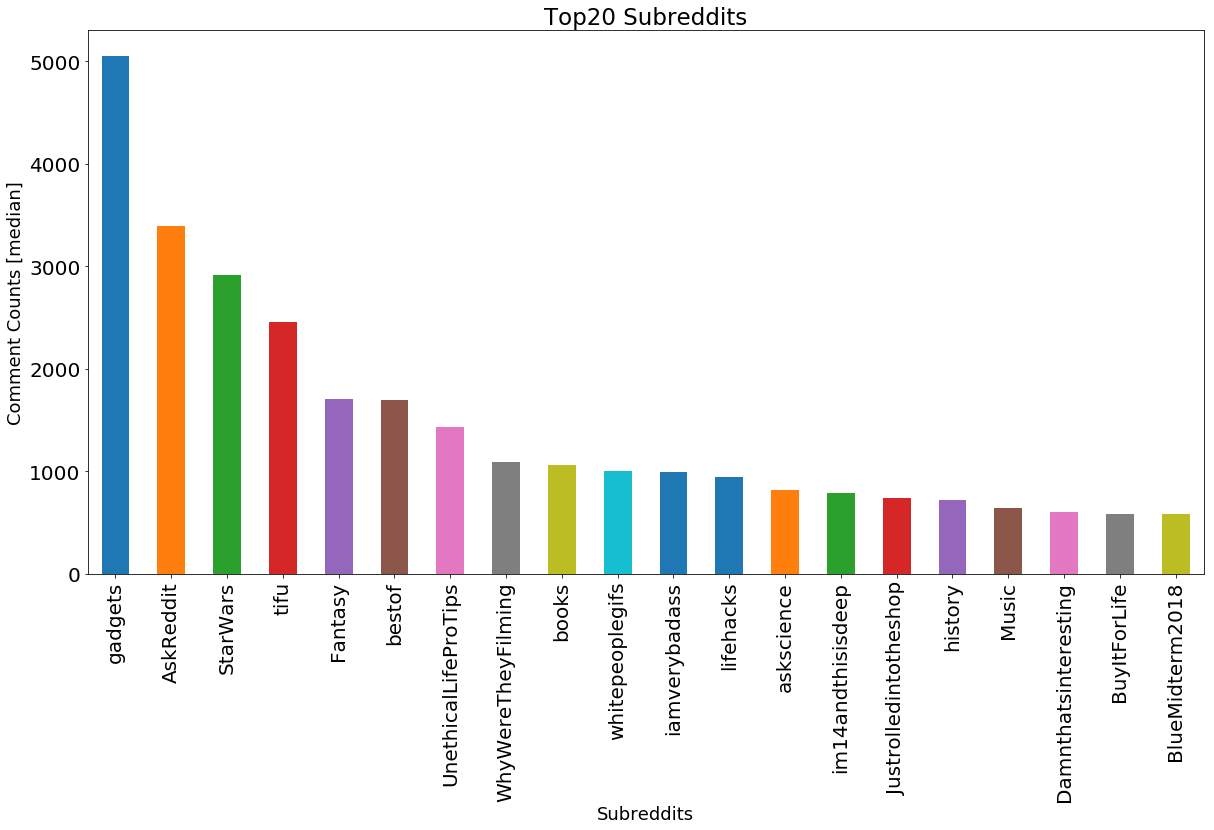

In [24]:
#Top20 Subreddits
top20_subreddits_df = red.groupby('subreddits')['comment_cnts'].median().sort_values(ascending=False)[:20]

top20_subreddits_df.plot(x='comment_cnts',y='subreddits',kind='bar',fontsize=20 , figsize=(20,10))
plt.title('Top20 Subreddits',fontsize=23)
plt.xlabel('Subreddits',fontsize=18)
plt.ylabel('Comment Counts [median]',fontsize=18)
plt.xticks(rotation=90)
plt.show()

## EDA / Feature Engineering

In [25]:
#replacing T in times with a space to change to this format 2018-02-26 06:07:49
red['times'] = red['times'].str.replace('T',' ')

In [26]:
#converting times column into a datetime dtype
red['times'] = pd.to_datetime(red['times'])

In [27]:
#Create a column for hour
red['hour'] = red['times'].dt.hour

In [28]:
#Medain value for determine classes 
red['comment_cnts'].median()

45.0

In [29]:
#split up data into categories for above and below median of 45.0 
red['above_below'] = (red['comment_cnts'] > (red['comment_cnts'].median())).astype(int)

In [30]:
#datetime(year, month, day[, hour[, minute[, second[, microsecond[,tzinfo]]]]])
stop_scrape = pd.datetime(2018, 2, 26, 7, 40)
red['time_delta'] = stop_scrape - red['times'] #created a feature for a quazi time delta referenced to when scraping was stopped

In [31]:
red.head()

,authors,comment_cnts,pictures,subreddits,times,titles,user_ids,videos,hour,above_below,time_delta
0,MrEthelWulf,74.0,1.0,OnePiece,2018-02-26 06:07:49,The only guy badass enough to not name his att...,t3_80au1m,1.0,6,1,01:32:11
1,rust4ryfe,28.0,1.0,shittyfoodporn,2018-02-26 04:32:12,Waffles from Local Chinese Grocery Store,t3_80ab4s,1.0,4,0,03:07:48
2,JerryfromTomandJerry,5.0,1.0,holdmycatnip,2018-02-26 06:32:54,HMC while I assimilate with this paper,t3_80ayow,1.0,6,0,01:07:06
3,Chrismite,41.0,1.0,runescape,2018-02-26 02:21:35,Meanwhile in w84 lumby,t3_809jp5,1.0,2,0,05:18:25
4,sourpatchkidj,16.0,1.0,gaybros,2018-02-26 00:45:11,1 out of 10,t3_808yct,0.0,0,0,06:54:49


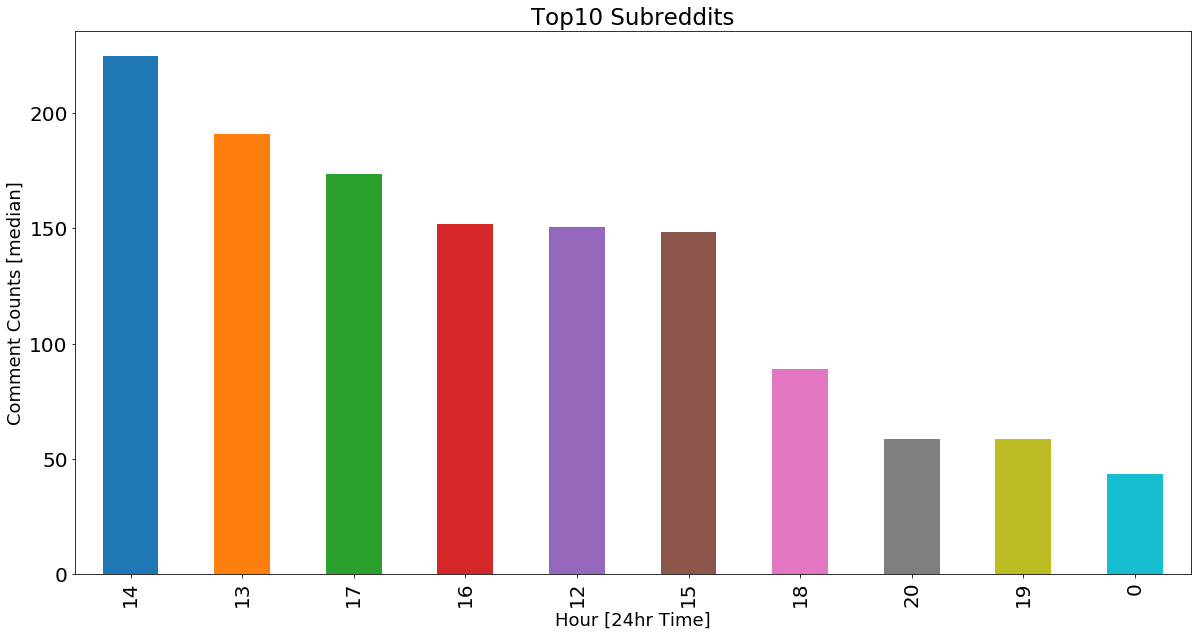

In [32]:
#Top10 times of day for highest comment traffic
#After lunch (1PM - 2PM ) have the highest traffic between Sunday and Early Monday. Most likely due to weekend.
high_traffic_hours = red.groupby('hour')['comment_cnts'].median().sort_values(ascending=False)[:10]

high_traffic_hours.plot(x='comment_cnts',y='hour',kind='bar',fontsize=20 , figsize=(20,10))
plt.title('Top10 Subreddits',fontsize=23)
plt.xlabel('Hour [24hr Time]',fontsize=18)
plt.ylabel('Comment Counts [median]',fontsize=18)
plt.xticks(rotation=90)
plt.show()

## Predicting comments using Random Forests + Another Classifier

#### Load in the the data of scraped results

In [21]:
## YOUR CODE HERE
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier

/Users/guillermogonzalez/miniconda3/envs/ga/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Train Test Split for Count Vectorizing Titles

In [33]:
X = red['titles']
# X = red.copy().drop(['above_below','comment_cnts','times','time_delta'], axis=1) #remove target and comments_cnts which makes the target
y = red['above_below']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)

In [34]:
print(X_train.shape,'\n',y_train.shape, '\n',X_test.shape, '\n',y_test.shape)

(1011,) 
 (1011,) 
 (253,) 
 (253,)


In [35]:
#
cvec = CountVectorizer(stop_words='english', lowercase=True )
vectorizers = cvec.fit_transform(X_train)

In [36]:
vectorizers.shape

(1011, 3318)

In [37]:
red_x = pd.DataFrame(vectorizers.todense(),
             columns=cvec.get_feature_names())

In [38]:
#CountVectorized titles shape
red_x.shape

(1011, 3318)

In [40]:
#Glimpse of the CountVectorized titles
red_x.head()

,000,000th,06,08,10,100,1024x768,1066,1068,10th,...,youtuber,yrs,yuo,zack,zelda,zip,zoomba,zuko,김성규,엔시티
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### KNN with CountVectorized Titles

In [41]:
neighs = KNeighborsClassifier() #instantiating the KNN model
model = neighs.fit(red_x, y_train) #fitting the CountVectorized titles training data (red_x) and y_train
vectorizers_test = cvec.transform(X_test) #Tranform the X_test from the Train/Test split above 
df_test = pd.DataFrame(vectorizers_test.todense(), 
             columns=cvec.get_feature_names())

In [42]:
#KNN model accuracy yields results close to the baseline accuracy of 0.50
model.score(df_test, y_test)

0.5138339920948617

In [43]:
probs = model.predict_proba(df_test)

probs_col = pd.DataFrame(probs, columns = ['prob pos','prob neg']).reset_index(drop=True)
X_col = pd.DataFrame(X_test, columns=['titles']).reset_index(drop=True)
y_col = y_test.to_frame().reset_index(drop=True)

df_probs = pd.concat([X_col, y_col, probs_col], axis=1)

df_probs.head(10)

,titles,above_below,prob pos,prob neg
0,"Missing the 360 Wireless Headset, Try this.",1,0.8,0.2
1,How did Voyager 1 send back images of earth? F...,1,0.6,0.4
2,Flossing is gay,0,0.8,0.2
3,Made a small modular to cover the side of othe...,0,0.6,0.4
4,When there are more rules added to /r/PrequelM...,1,0.6,0.4
5,Liberty + Temmie,0,0.6,0.4
6,"""We dont have the budget to secure schools""",1,0.6,0.4
7,"""He guards the tomatoes.""",0,0.6,0.4
8,"The real reason we're here...because ""currency...",0,0.6,0.4
9,New Data Gives Credence To The Prevailing Sent...,1,0.6,0.4


In [44]:
# Titles that don't have a strong contribution to reddit comment_cnts
df_probs[ (df_probs['prob pos'] < 0.7) & (df_probs['prob pos'] > 0.4) ]

,titles,above_below,prob pos,prob neg
1,How did Voyager 1 send back images of earth? F...,1,0.6,0.4
3,Made a small modular to cover the side of othe...,0,0.6,0.4
4,When there are more rules added to /r/PrequelM...,1,0.6,0.4
5,Liberty + Temmie,0,0.6,0.4
6,"""We dont have the budget to secure schools""",1,0.6,0.4
7,"""He guards the tomatoes.""",0,0.6,0.4
8,"The real reason we're here...because ""currency...",0,0.6,0.4
9,New Data Gives Credence To The Prevailing Sent...,1,0.6,0.4
10,Aja is saying everything we were thinking last...,1,0.6,0.4
11,OP x MUFC | A commisson I recently finished [f...,1,0.6,0.4


In [45]:
#Titles with a predcit probability >0.7
df_probs[ (df_probs['prob pos'] > 0.7)]

,titles,above_below,prob pos,prob neg
0,"Missing the 360 Wireless Headset, Try this.",1,0.8,0.2
2,Flossing is gay,0,0.8,0.2
12,I know you stole my ping pong ball.,1,0.8,0.2
15,I drew Pukei Pukei,0,0.8,0.2
18,Celebrity Big Brother (U.S.) winner announced!...,1,0.8,0.2
26,Not Ken M on Academia,0,0.8,0.2
37,"ELI5: On a wine label ""grapes picked at night ...",1,0.8,0.2
39,Ancient Necropolis in Egypt discovered,1,0.8,0.2
40,Jake Matthews‏ giving away a boomerang signed ...,1,0.8,0.2
41,A few extra days won't hurt,0,0.8,0.2


#### We want to predict a binary variable - whether the number of comments was low or high. Compute the median number of comments and create a new binary variable that is true when the number of comments is high (above the median)

We could also perform Linear Regression (or any regression) to predict the number of comments here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW number of comments.

While performing regression may be better, performing classification may help remove some of the noise of the extremely popular threads. We don't _have_ to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of comment numbers. 

## Decision Trees

In [46]:
from sklearn.preprocessing import LabelEncoder

#Assigning X and y variables to use in the train / test  split 
y = LabelEncoder().fit_transform(red['above_below'])
X = pd.get_dummies(red.copy().drop(['above_below', 'comment_cnts', 'times','time_delta'], axis=1))

### Random Forest Classifier

In [47]:
cv = StratifiedKFold(y, n_folds=3, shuffle=True, random_state=42)

rf = RandomForestClassifier(class_weight='balanced')
s = cross_val_score(rf, X, y, cv=cv, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

#Random Forest accuracy of 0.64, 14% better than baseline

Random Forest Score:	0.668 ± 0.014


In [54]:
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [79]:
important_features = pd.Series(data=rf.feature_importances_, index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features.head())

hour                 0.083320
videos               0.026862
subreddits_videos    0.008996
subreddits_pics      0.008502
pictures             0.005771
dtype: float64


In [80]:
important_features

pandas.core.series.Series

In [68]:
rf.feature_importances_.tolist()

[0.005771357594091727,
 0.026862497765098813,
 0.08332005584064076,
 0.0,
 0.0,
 1.09230919834494e-05,
 0.00020129420535810682,
 4.3776739828372915e-06,
 0.00018750140854096171,
 0.0,
 0.0,
 0.0,
 4.0371994158956986e-08,
 0.0,
 6.848744581511776e-05,
 0.0002254444167239976,
 0.0,
 0.0,
 0.0004947650248547365,
 5.609138141366247e-05,
 0.0,
 0.0,
 0.0,
 4.540718765958467e-05,
 0.0,
 1.1687056161292363e-05,
 0.00035364184817385854,
 0.0009426935439857717,
 0.0,
 0.0001804904905982054,
 4.201366707693829e-05,
 0.0,
 0.002068745493840011,
 5.268076486096038e-06,
 0.00019798444058012976,
 0.0013907959129172826,
 0.0,
 4.856682209173206e-06,
 0.0007576011549417902,
 0.00029751487224590444,
 0.0,
 0.0,
 1.7592280285168587e-06,
 6.240404667606741e-05,
 0.00026504701689463947,
 0.0001238394543061462,
 0.00024528941979890017,
 0.0005246618253038993,
 0.0,
 0.0002757571308989975,
 0.0,
 7.71469166018405e-05,
 1.2125701656949251e-05,
 0.0001167721438191067,
 0.0001273391105401479,
 0.0,
 0.0,
 0.0,

### Bagging Classifier

In [51]:
bc = BaggingClassifier()
s = cross_val_score(bc, X, y, cv=cv, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Bagging", s.mean().round(3), s.std().round(3)))

#Random Forest accuracy of 0.66, 16% better than baseline

Bagging Score:	0.666 ± 0.02


In [69]:
bc.fit(X,y)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [77]:
important_features = pd.Series(data=bc.feature_importances_, index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features)

AttributeError: 'BaggingClassifier' object has no attribute 'feature_importances_'

#### We want to predict a binary variable - whether the number of comments was low or high. Compute the median number of comments and create a new binary variable that is true when the number of comments is high (above the median)

We could also perform Linear Regression (or any regression) to predict the number of comments here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW number of comments.

While performing regression may be better, performing classification may help remove some of the noise of the extremely popular threads. We don't _have_ to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of comment numbers. 

#### Thought experiment: What is the baseline accuracy for this model?

In [1345]:
## Baseline accuracy is 0.50 since the median was used as the boundry between above and below
red['above_below'].value_counts()[1] / red['above_below'].value_counts().sum()

0.495253164556962

In [1350]:
#Class balance of above and below the median (not exactly 50/50 since some NaN rows were removed)
red['above_below'].value_counts()

0    638
1    626
Name: above_below, dtype: int64

#### Create a few new variables in your dataframe to represent interesting features of a thread title.
- For example, create a feature that represents whether 'cat' is in the title or whether 'funny' is in the title. 
- Then build a new Random Forest with these features. Do they add any value?
- After creating these variables, use count-vectorizer to create features based on the words in the thread titles.
- Build a new random forest model with subreddit and these new features included.

In [ ]:
## YOUR CODE HERE

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 

In [ ]:
## YOUR CODE HERE

#### Repeat the model-building process with a non-tree-based method.

In [ ]:
## YOUR CODE HERE

#### Use Count Vectorizer from scikit-learn to create features from the thread titles. 
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [ ]:
## YOUR CODE HERE

# Executive Summary
---
Put your executive summary in a Markdown cell below.

### BONUS
Refer to the README for the bonus parts

In [ ]:
## YOUR CODE HERE